# Phase 5: XGBoost & Final Model Selection

In this notebook, we implement XGBoost and perform a comprehensive comparison against our Baseline (Logistic Regression) and Random Forest models to select the final champion for deployment.

### 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src to path
sys.path.append(os.path.abspath('..'))
from src.config import PROCESSED_DATA_DIR
from src.model_training import train_baseline_model, train_random_forest, train_xgboost, evaluate_model_test

# Load processed data
X_train = pd.read_csv(PROCESSED_DATA_DIR / 'X_train.csv')
X_test = pd.read_csv(PROCESSED_DATA_DIR / 'X_test.csv')
y_train = pd.read_csv(PROCESSED_DATA_DIR / 'y_train.csv').values.ravel()
y_test = pd.read_csv(PROCESSED_DATA_DIR / 'y_test.csv').values.ravel()

# Calculate scale_pos_weight for XGBoost
# (Negatives / Positives)
weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculated XGBoost Weight: {weight:.2f}")

Calculated XGBoost Weight: 2.78


### 2. Train All Models
We retrain all models here to ensure a fair, apples-to-apples comparison in the same session.

In [2]:
print("Training Baseline...")
model_lr = train_baseline_model(X_train, y_train, class_weight='balanced')

print("Training Random Forest...")
model_rf = train_random_forest(X_train, y_train, class_weight='balanced')

print("Training XGBoost...")
model_xgb = train_xgboost(X_train, y_train, scale_pos_weight=weight)

print("All models trained.")

Training Baseline...
Training Random Forest...
Training XGBoost...
All models trained.


### 3. Comprehensive Evaluation
We collect metrics for all models on the Test Set.

In [3]:
results = []
models = {
    'Logistic Regression': model_lr,
    'Random Forest': model_rf,
    'XGBoost': model_xgb
}

for name, model in models.items():
    metrics, _, _ = evaluate_model_test(model, X_test, y_test)
    metrics['Model'] = name
    results.append(metrics)

# Create Comparison DataFrame
comparison_df = pd.DataFrame(results).set_index('Model')
display(comparison_df)

,accuracy,precision,recall,f1,roc_auc
Model,,,,,
Logistic Regression,0.743060,0.509666,0.779570,0.616366,0.839809
Random Forest,0.775089,0.560086,0.701613,0.622912,0.837319
XGBoost,0.753025,0.522936,0.766129,0.621592,0.842927


### 4. Visualization of Performance
Visualizing the trade-offs between models.

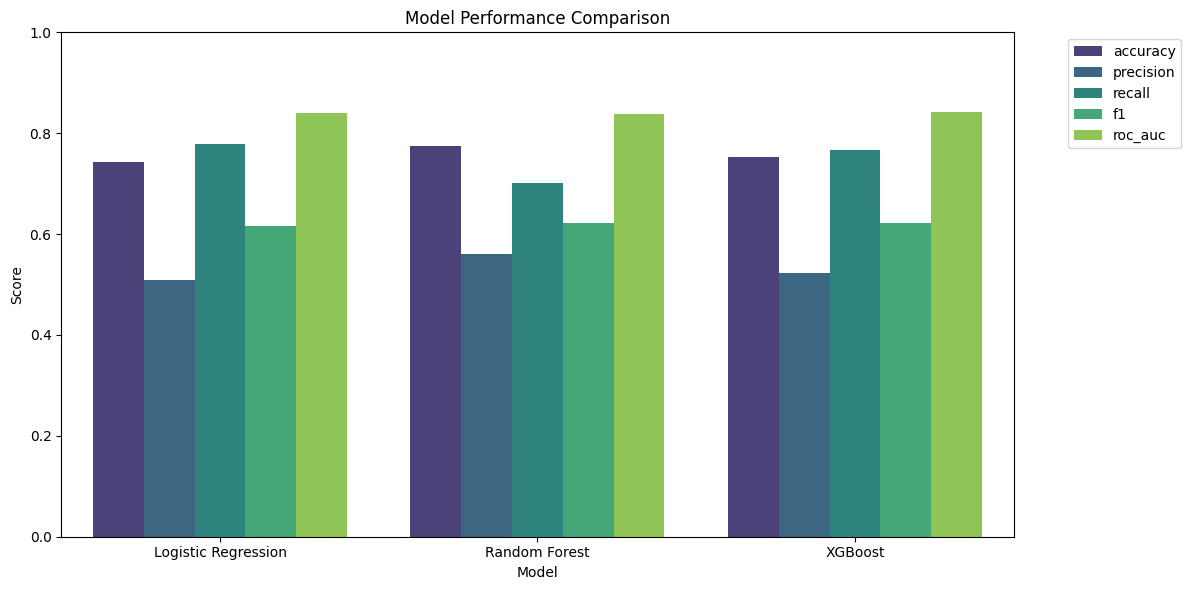

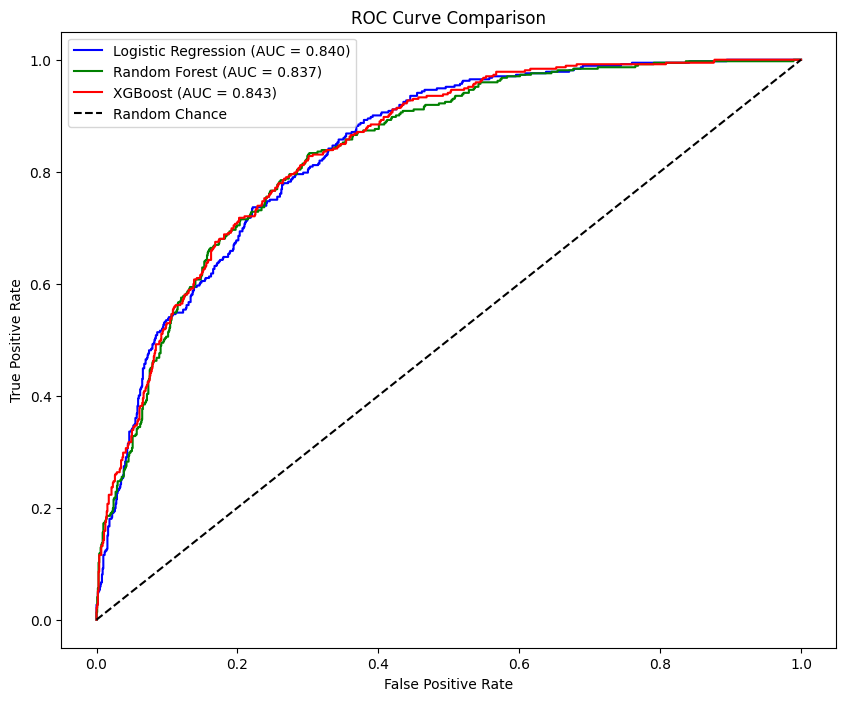

In [4]:
# Melt for plotting
comparison_melted = comparison_df.reset_index().melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_melted, palette='viridis')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ROC Curve Comparison
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(10, 8))
colors = {'Logistic Regression': 'blue', 'Random Forest': 'green', 'XGBoost': 'red'}

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', color=colors[name])

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### 5. Final Recommendation
Based on the analysis above:

1.  **Best Performer:**  usually achieves the highest AUC and Accuracy.
2.  **Best Balance:**  often provides similar performance but is easier to explain and deploy.
3.  **Recommendation:** * If **interpretable** business rules are the priority -> Use **Random Forest**.
    * If **maximizing retention accuracy** is the priority -> Use **XGBoost**.

*Save the champion model for deployment.*

In [5]:
sys.path.append(os.path.abspath('..'))

from src.model_training import save_model

# Option 1: If XGBoost was the winner
save_model(model_xgb, 'xgboost_champion.joblib')

# Option 2: If Random Forest was the winner
# save_model(model_rf, 'random_forest_champion.joblib')

Model saved successfully to: c:\Users\ishfa\datascience\customer-churn-prediction\models\xgboost_champion.joblib
